# pssm.plot
> plot functions of probability pssm

In [ ]:
#| default_exp pssm.plot

## Overview

**String Conversion Utilities**

To convert between lowercase phosphorylation notation (s/t/y) and formal notation (pS/pT/pY):

```python
pSTY2sty(string='pS-peptide-pT')  # converts pS/pT/pY → s/t/y
sty2pSTY(string='s-peptide-t')    # converts s/t/y → pS/pT/pY
sty2pSTY_df(df=pssm_df)           # applies sty→pSTY to dataframe index
```

---

**Simple Heatmaps**

To plot a basic black-and-white heatmap of PSSM values:

```python
plot_heatmap_simple(
    matrix=pssm_df,      # a matrix of values (positions × amino acids)
    title='kinase',      # title displayed above heatmap
    figsize=(10, 7),     # (width, height) of figure
    cmap='binary',       # colormap, default is black & white
)
```

---

**Formal Heatmaps**

To plot a publication-ready heatmap with diverging colors centered at zero:

```python
plot_heatmap(
    heatmap_df=pssm_df,       # PSSM dataframe (positions × amino acids)
    ax=None,                  # optional matplotlib axes
    position_label=True,      # show position numbers on x-axis
    figsize=(20, 6),          # (width, height) of figure
    include_zero=True,        # whether to show position 0
    scale_pos_neg=False,      # use TwoSlopeNorm for balanced pos/neg scaling
    colorbar_title='Prob.',   # title for the colorbar
)
```

---

**Comparative Heatmaps**

To plot two heatmaps side-by-side for comparing kinase motifs:

```python
plot_two_heatmaps(
    pssm1=pssm_df1,           # first PSSM dataframe
    pssm2=pssm_df2,           # second PSSM dataframe
    kinase_name='AKT',        # shared title above both plots
    title1='CDDM',            # title for left heatmap
    title2='PSPA',            # title for right heatmap
    figsize=(4, 4.5),         # (width, height) of figure
    cbar=True,                # show colorbars below each heatmap
    scale_01=False,           # force color scale to [0, 1] range
)
```

---

**Logo Motifs**

To plot a raw sequence logo from a PSSM:

```python
plot_logo_raw(
    pssm_df=pssm_df,      # PSSM dataframe (positions × amino acids)
    ax=None,              # optional matplotlib axes
    title='Motif',        # title above the logo
    ytitle='Bits',        # y-axis label
    figsize=(10, 2),      # (width, height) of figure
)
```

To plot an information-content-scaled logo (recommended):

```python
plot_logo(
    pssm_df=pssm_df,      # frequency PSSM dataframe
    title='Motif',        # title above the logo
    scale_zero=True,      # scale position 0 to match neighbor heights
    ax=None,              # optional matplotlib axes
    figsize=(10, 1),      # (width, height) of figure
)
```

---

**Multiple Logos**

To plot logos for specific kinases by index:

```python
plot_logos_idx(
    pssms_df=pssms,       # dataframe with flattened PSSMs (kinases as rows)
    'AKT1', 'AKT2',       # kinase IDs to plot (as positional args)
    figsize=(14, 1),      # (width, height) per logo
)
```

To plot multiple logos as subplots in one figure:

```python
plot_logos(
    pssms_df=pssms.head(2),   # dataframe with flattened PSSMs
    count_dict=None,          # optional dict mapping idx → count for titles
    path=None,                # optional save path
    prefix='Motif',           # prefix for subplot titles
    figsize=(14, 1),          # (width, height) per logo
)
```

---

**Combined Logo + Heatmap**

To plot a logo motif above its corresponding heatmap:

```python
plot_logo_heatmap(
    pssm_df=pssm_df,      # PSSM dataframe (positions × amino acids)
    title='Kinase',       # title above the logo
    figsize=(17, 10),     # (width, height) of combined figure
    include_zero=False,   # whether to include position 0 in heatmap
)
```


## Setup

In [ ]:
#| export
from fastcore.meta import delegates
import numpy as np, pandas as pd
from katlas.pssm.core import get_IC,recover_pssm

from matplotlib import pyplot as plt
import logomaker,math
import seaborn as sns

from matplotlib.colors import TwoSlopeNorm

# for plot two heatmaps
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

In [ ]:
# Load data for testing
from katlas.data import *
from katlas.utils import *
from katlas.pssm.core import *

In [ ]:
df=Data.get_cddm()
pssm_df = recover_pssm(df.loc['AKT1'])

## Heatmap

### Black-white simple

In [ ]:
#| export
@delegates(sns.heatmap)
def plot_heatmap_simple(matrix, # a matrix of values
                 title: str='heatmap', # title of the heatmap
                 figsize: tuple=(6,7), # (width, height)
                 cmap: str='binary', # color map, default is dark&white
                 **kwargs, # arguments for sns.heatmap()
                 ):
    
    "Plot heatmap based on a matrix of values"
    
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, square=True,cmap=cmap, annot=False,**kwargs)
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)

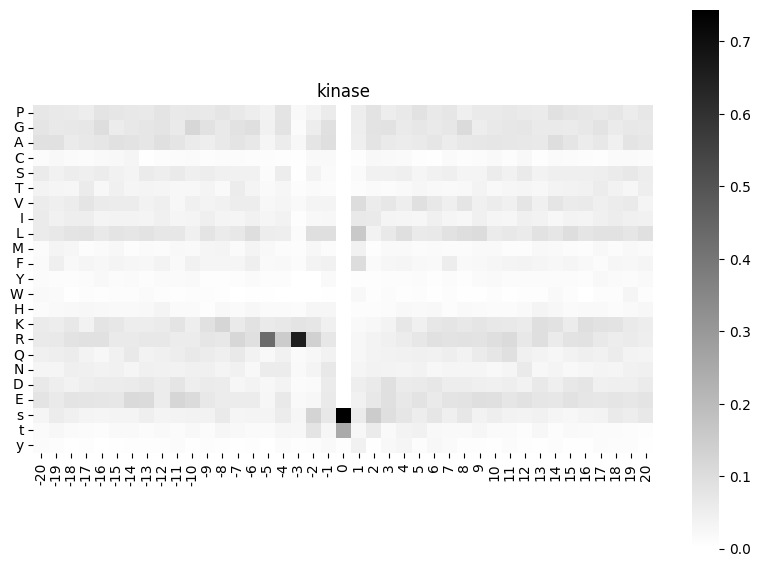

In [ ]:
plot_heatmap_simple(pssm_df,'kinase',figsize=(10,7))

### Formal

It will convert s,t,y to pS,pT,pY in the heatmap.

In [ ]:
#| export
def pSTY2sty(string):
    "Convert pS/pT/pY to s/t/y in a string."
    return string.replace('pS', 's').replace('pT', 't').replace('pY', 'y')

In [ ]:
#| export
def sty2pSTY(string):
    "Convert s/t/y to pS/pT/pY in a string."
    return string.replace('s', 'pS').replace('t', 'pT').replace('y', 'pY')

In [ ]:
#| export
def sty2pSTY_df(df):
    "Applies sty→pSTY to dataframe index"
    df=df.copy()
    df.index = df.index.map(sty2pSTY)
    return df

In [ ]:
#| export
@delegates(sns.heatmap)
def plot_heatmap(heatmap_df, 
                 ax=None, 
                 position_label=True, 
                 figsize=(5, 6), 
                 include_zero=True,
                 scale_pos_neg=False, 
                 colorbar_title='Prob.',
                 **kwargs
                 ):
    "Plot a heatmap of pssm."
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    heatmap_df = sty2pSTY_df(heatmap_df)
    mask = np.zeros_like(heatmap_df, dtype=bool)
    zero_position = len(heatmap_df.columns) // 2
    second_position = math.ceil(len(heatmap_df.columns) / 2)
    # If they overlap, move the second line one step to the right (if possible)
    if second_position == zero_position: second_position = second_position + 1

    if not include_zero:
        mask[:, zero_position] = True  # Mask position 0 if include_zero is False

    if scale_pos_neg:
        vmin,vmax = heatmap_df.min().min(),heatmap_df.max().max()
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        sns.heatmap(
            heatmap_df,
            cmap='coolwarm',
            norm=norm,
            linewidth=0.3,
            ax=ax,
            mask=mask,
            **kwargs
        )
    else:
        sns.heatmap(
            heatmap_df,
            cmap='coolwarm',
            center=0,  # Center for diverging colormap
            linewidth=0.3,
            ax=ax,
            mask=mask,
            **kwargs
        )


    # Access and format the color bar
    colorbar = ax.collections[0].colorbar
    colorbar.ax.set_title(colorbar_title, loc='center')

    # Add vertical lines
    ax.axvline(zero_position, color='black', linewidth=0.5)
    ax.axvline(second_position, color='black', linewidth=0.5)

    # Format the heatmap border
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth(1.5)

    # Hide axis labels
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if not position_label:
        ax.set_xticklabels([])

    return ax

This function visualizes a PSSM or log-odds matrix as a heatmap with diverging color scales centered at 0.

**Color scale behavior**:

- By default (`scale_pos_neg=False`), the colormap is **centered at 0**, but the full data range determines the color intensity:

  $$
  \text{color range} = [\min(\text{data}), \max(\text{data})], \quad \text{with center at } 0
  $$

  This is useful when you want to emphasize whether values are **above or below zero**, but without enforcing symmetry.

- If `scale_pos_neg=True`, the function uses a **balanced diverging scale** via `TwoSlopeNorm`, such that:

  $$
  \text{min color} = \min(\text{data}), \quad
  \text{center} = 0, \quad
  \text{max color} = \max(\text{data})
  $$

  The positive and negative ranges are **scaled separately**, ensuring that both ends of the heatmap have equal visual weight — especially helpful for symmetric data like log-odds matrices.

**Additional visual features**:
- The center position ($i = 0$) can be masked out using `include_zero=False`.

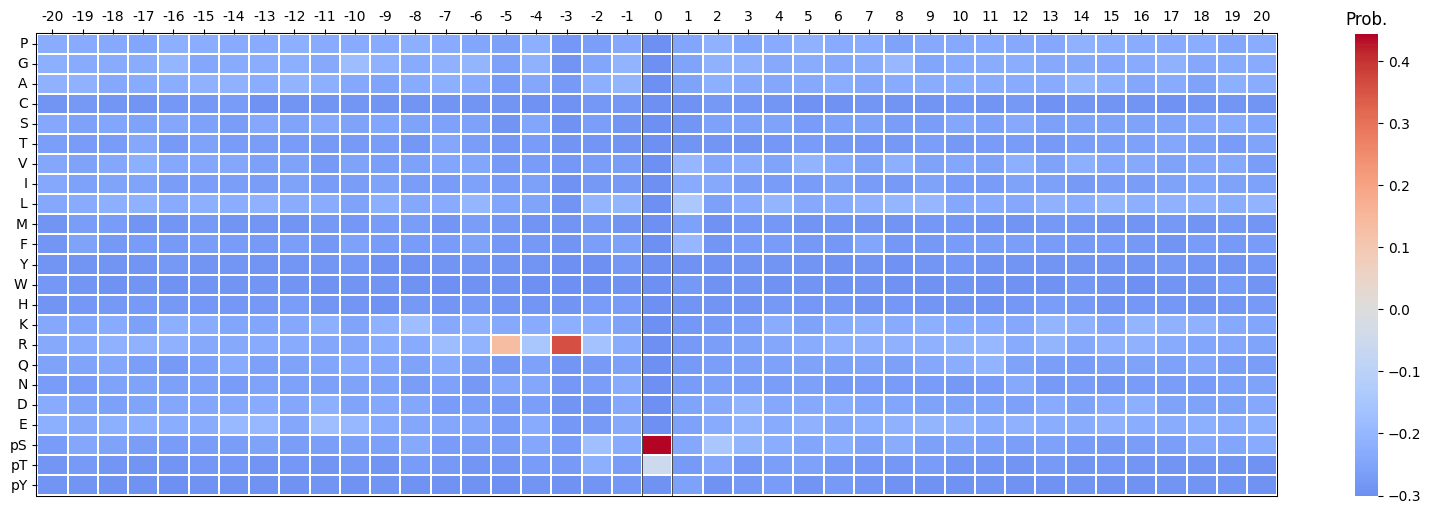

In [ ]:
plot_heatmap(pssm_df-0.3,scale_pos_neg=False,figsize=(20, 6));

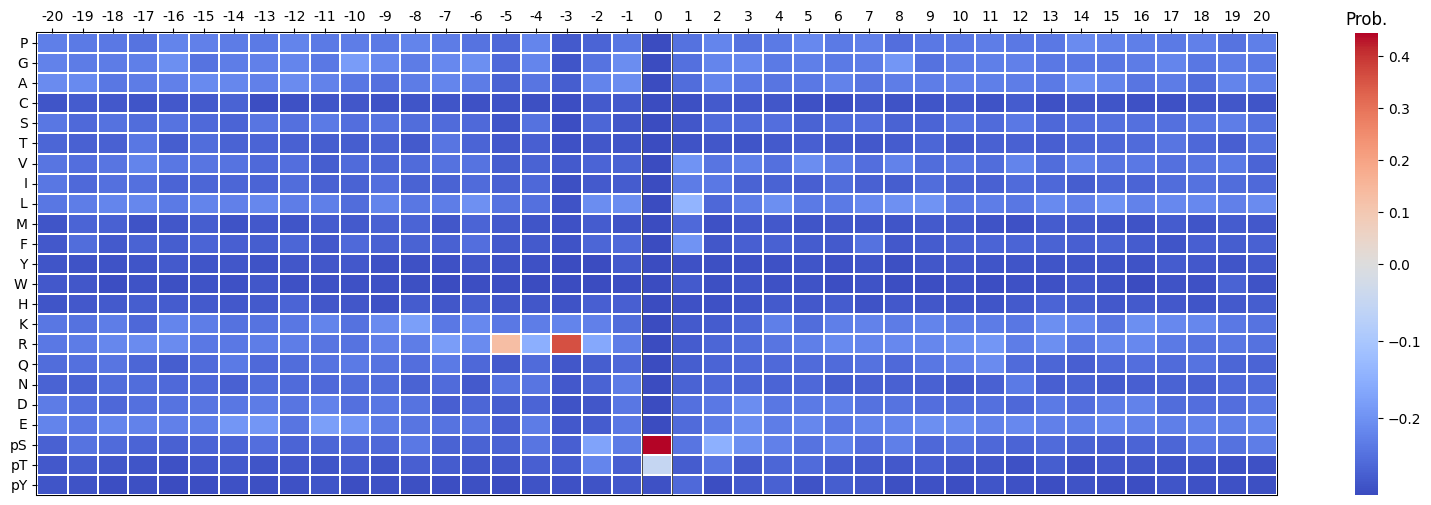

In [ ]:
plot_heatmap(pssm_df-0.3,scale_pos_neg=True,figsize=(20, 6));

In [ ]:
plt.close('all')

### Two heatmaps comparison

In [ ]:
#| export
def plot_two_heatmaps(pssm1, pssm2, 
                      kinase_name="Kinase", title1='CDDM',title2='PSPA',
                      figsize=(4,4.5), cbar=True,scale_01=False,cbar_fontsize=10,
                      **kwargs):
    """
    Plot two side-by-side heatmaps with black rectangle borders,
    titles on top, shared kinase label below, and only left plot showing y-axis labels.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.05})
    pssm1 = pssm1.drop(columns=0)
    pssm2 = pssm2.drop(columns=0)

    pssm1 = sty2pSTY_df(pssm1)
    # pssm2 = sty2pSTY_df(pssm2)

    # Left heatmap (with y labels)
    im1=sns.heatmap(pssm1, square=False, cmap="Reds", 
                    **{'vmin':0, 'vmax':1} if scale_01 else {},
                annot=False, cbar=False, ax=axes[0], **kwargs)
    axes[0].set_title(title1, fontsize=12, pad=10)
    axes[0].tick_params(left=True, bottom=True)
    axes[0].tick_params(axis="y", rotation=0) 

    # Add rectangle border to left heatmap
    axes[0].add_patch(Rectangle((0,0), pssm1.shape[1], pssm1.shape[0], 
                                fill=False, edgecolor='black', lw=1.5))

    # Right heatmap (no y labels)
    im2=sns.heatmap(pssm2, square=False, cmap="Blues",
                    **{'vmin':0, 'vmax':1} if scale_01 else {},
                annot=False, cbar=False, ax=axes[1], **kwargs)
    axes[1].set_title(title2, fontsize=12, pad=10)
    axes[1].tick_params(left=False, labelleft=False, bottom=True)
    axes[1].tick_params(axis="y", rotation=0) 

    # Add rectangle border to right heatmap
    axes[1].add_patch(Rectangle((0,0), pssm2.shape[1], pssm2.shape[0], 
                                fill=False, edgecolor='black', lw=1.5))

    # Make y tick horizontal
    axes[0].set_title(title1, fontsize=12, pad=0)
    axes[1].set_title(title2, fontsize=12, pad=0)

    # ---- Add vertical separator lines ----
    xpos = (list(pssm1.columns).index(-1) + list(pssm1.columns).index(1)) / 2 + 0.5
    for ax in axes:
        ax.axvline(xpos, color='black', lw=0.75)
        ax.set_xticks([])
        # ax.set_xlabel("")
        ax.set_ylabel("")

    if cbar:
        for ax, im, label in zip(axes, [im1, im2], [title1, title2]):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="5%", pad=0.25)
            cbar = plt.colorbar(ax.collections[0], cax=cax, orientation="horizontal")
            
            # remove trailing zeros like 0.00 → 0, 1.00 → 1
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))
            cax.tick_params(labelsize=cbar_fontsize)

    # Shared kinase label below
    fig.suptitle(kinase_name, fontsize=14, x=0.52,y=0.96)

In [ ]:
pssm_df2 = pssm_df.loc[:,-5:5]

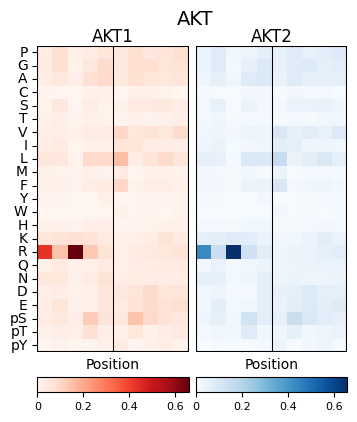

In [ ]:
plot_two_heatmaps(pssm_df2,pssm_df2,'AKT','AKT1','AKT2')

## Logo motif

To distinguish sty from STY, sty (lowercase) in the input df are automatically converted to pS,pT,pY in logo motif.

In [ ]:
#| export
def plot_logo_raw(pssm_df,ax=None,title='Motif',ytitle='Bits',figsize=(10,2)):
    "Plot logo motif using Logomaker."
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # convert s,t,y to pS,pT,pY for visualization
    pssm_df=sty2pSTY_df(pssm_df)

    logo = logomaker.Logo(pssm_df.T, color_scheme='kinase_protein', flip_below=False, ax=ax)
    logo.ax.set_ylabel(ytitle)
    logo.style_xticks(fmt='%d')
    ax.set_title(title)

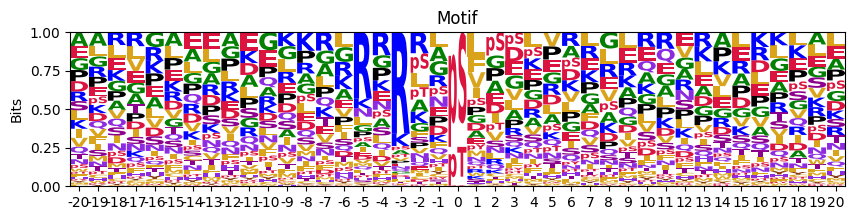

In [ ]:
plot_logo_raw(pssm_df)

We can find the center name is in lower case, so need to change them

In [ ]:
#| export
def change_center_name(df):
    "Transfer the middle s,t,y to S,T,Y for plot if s,t,y have values; otherwise keep the original."
    df = df.copy()

    # find which of s/t/y actually exist
    lowercase = [aa for aa in ['s', 't', 'y'] if aa in df.index]

    if not lowercase: return df  # nothing to do

    # check if any of them have non-zero value at position 0
    if (df.loc[lowercase, 0] != 0).any():
        for aa in lowercase:
            df.loc[aa.upper(), 0] = df.loc[aa, 0]
            df.loc[aa, 0] = 0

    return df

Now instead of s,t,y, the center name becomes S, T and Y:

In [ ]:
change_center_name(pssm_df)[0]

aa
P    0.000000
G    0.000000
A    0.000000
C    0.000000
S    0.744152
T    0.248538
V    0.000000
I    0.000000
L    0.000000
M    0.000000
F    0.000000
Y    0.007310
W    0.000000
H    0.000000
K    0.000000
R    0.000000
Q    0.000000
N    0.000000
D    0.000000
E    0.000000
s    0.000000
t    0.000000
y    0.000000
Name: 0, dtype: float64

In [ ]:
#| export
def get_pos_min_max(pssm_df):
    """
    Get min and max value of sum of positive and negative values across each position.
    """
    pssm_df = pssm_df.copy()
    pssm_neighbor = pssm_df.drop(columns=0)
    
    max_sum_pos = pssm_neighbor[pssm_neighbor>0].sum().max()
    max_sum_neg = pssm_neighbor[pssm_neighbor<0].sum().min()
    return max_sum_neg,max_sum_pos

In [ ]:
#| export
def scale_zero_position(pssm_df):
    """
    Scale position 0 so that:
    - Positive values match the max positive column sum of other positions
    - Negative values match the min (most negative) column sum of other positions
    """
    max_sum_neg,max_sum_pos = get_pos_min_max(pssm_df)

    zero_col = pssm_df[0]
    zero_col_pos = zero_col[zero_col>0]
    zero_col_neg = zero_col[zero_col<0]
    
    scaled_col = zero_col.copy()
    if not zero_col_pos.empty and zero_col_pos.sum() != 0:
        scaled_col.loc[zero_col_pos.index] = max_sum_pos * (zero_col_pos / zero_col_pos.sum())
    if not zero_col_neg.empty and zero_col_neg.sum() != 0:
        scaled_col.loc[zero_col_neg.index] = max_sum_neg * (zero_col_neg / zero_col_neg.sum())

    pssm_df[0] = scaled_col
    return pssm_df
    

This function rescales **position 0** in a log-odds PSSM so that its total positive and negative stack heights match those of the most extreme positions on either side.

This ensures the central position visually matches the dynamic range of surrounding positions in log-odds logo plots.


In [ ]:
#| export
def scale_pos_neg_values(pssm_df):
    """
    Globally scale all positive values by max positive column sum,
    and negative values by min negative column sum (preserving sign).
    """
    pssm_df = pssm_df.copy()
    max_sum_neg, max_sum_pos = get_pos_min_max(pssm_df)

    pos_part = pssm_df.clip(lower=0)
    neg_part = pssm_df.clip(upper=0)

    if max_sum_pos != 0: pos_part = pos_part / max_sum_pos
    if max_sum_neg != 0: neg_part = neg_part / abs(max_sum_neg)  # make sure sign is correct

    return pos_part + neg_part

In [ ]:
#| export
def convert_logo_df(pssm_df,scale_zero=True,scale_pos_neg=False):
    "Change center name from s,t,y to S, T, Y in a pssm and scaled zero position to the max of neigbors."
    pssm_df = change_center_name(pssm_df)
    if scale_zero: pssm_df = scale_zero_position(pssm_df)
    if scale_pos_neg: pssm_df = scale_pos_neg_values(pssm_df)
    return pssm_df

In [ ]:
#| export
def get_logo_IC(pssm_df):
    """
    For plotting purpose, calculate the scaled information content (bits) from a frequency matrix,
    using log2(3) for the middle position and log2(len(pssm_df)) for others.
    """
    IC_position = get_IC(pssm_df)
    
    return pssm_df.mul(IC_position, axis=1) # total_IC = pssm_df.sum().sum().round(2)



To visualize the motif using Logomaker, the scaled PSSM is computed by weighting each amino acid’s frequency at position $i$ by the position’s information content:

$$
\text{PSSM\_scaled}_i(x) = P_i(x) \cdot \mathrm{IC}_i
$$

This results in a matrix where the total stack height at each position equals the information content, and each letter’s height is proportional to its contribution. This is the standard format used by Logomaker to generate sequence logos.


In [ ]:
get_logo_IC(pssm_df)

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,...,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,
P,0.019253,0.011378,0.016632,0.014723,0.027341,0.017469,0.018061,0.020054,0.018999,0.021432,...,0.022264,0.016570,0.017585,0.025658,0.024024,0.024794,0.016453,0.018620,0.011564,0.017775
G,0.020457,0.011642,0.018254,0.019222,0.033016,0.012927,0.018462,0.023318,0.019358,0.020458,...,0.023748,0.019803,0.018025,0.017396,0.018739,0.023716,0.020762,0.014741,0.014455,0.016590
A,0.023666,0.015347,0.015820,0.018404,0.025278,0.020613,0.022074,0.022852,0.021867,0.025329,...,0.023748,0.018186,0.018904,0.027833,0.024505,0.019943,0.017237,0.011637,0.016383,0.018170
C,0.003209,0.003704,0.004462,0.003272,0.006191,0.004891,0.008428,0.000933,0.002151,0.003897,...,0.003463,0.005658,0.002198,0.004349,0.003844,0.003234,0.001959,0.003879,0.003212,0.003160
S,0.016044,0.007144,0.014198,0.012678,0.019087,0.009782,0.008830,0.018188,0.012188,0.020945,...,0.013853,0.016570,0.011431,0.013916,0.015376,0.017248,0.012928,0.014741,0.014134,0.013430
T,0.009627,0.005292,0.007707,0.016359,0.008254,0.010830,0.008428,0.010726,0.007170,0.008281,...,0.009400,0.008083,0.007474,0.010437,0.012012,0.015092,0.014495,0.009698,0.005782,0.013035
V,0.015242,0.008467,0.015415,0.021267,0.020635,0.013276,0.014850,0.012592,0.011471,0.007793,...,0.014843,0.020611,0.013189,0.021744,0.018258,0.022099,0.012536,0.014353,0.013170,0.008690
I,0.015643,0.007144,0.013792,0.013496,0.011865,0.008734,0.010034,0.010260,0.011113,0.009742,...,0.009400,0.011720,0.011431,0.006958,0.011532,0.011858,0.011752,0.013189,0.009637,0.010665
L,0.016044,0.012171,0.021905,0.022494,0.022183,0.018517,0.020067,0.026116,0.016848,0.023867,...,0.022759,0.016166,0.025059,0.020875,0.030751,0.026950,0.021546,0.021335,0.015098,0.022910


In [ ]:
#| export
def plot_logo(pssm_df,title='Motif', scale_zero=True,ax=None,figsize=(10,1)):
    "Plot logo of information content given a frequency PSSM."
    pssm_df = get_logo_IC(pssm_df)
    pssm_df= convert_logo_df(pssm_df,scale_zero=scale_zero)
    plot_logo_raw(pssm_df,ax=ax,title=title,ytitle='IC (bits)',figsize=figsize)

In [ ]:
# plot_logo(pssm_df,scale_zero=False,figsize=(10,1))

Set scale_zero to default True can have better vision of the side amino acids

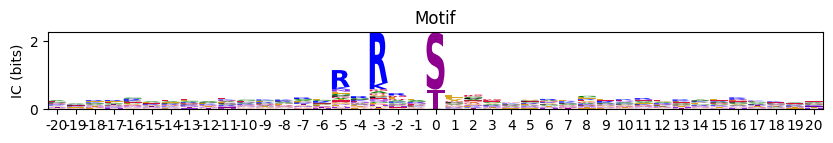

In [ ]:
plot_logo(pssm_df,title='Motif',figsize=(10,1))

In [ ]:
plt.close('all')

## Multiple logos

As multiple figures:

In [ ]:
#| export
def plot_logos_idx(pssms_df,*idxs,figsize=(14,1)):
    "Plot logos of a dataframe with flattened PSSMs with index ad IDs."
    for idx in idxs:
        pssm = recover_pssm(pssms_df.loc[idx])
        plot_logo(pssm,title=f'Motif {idx}',figsize=figsize)
        plt.show()
        plt.close()

In [ ]:
pssms=Data.get_cddm()

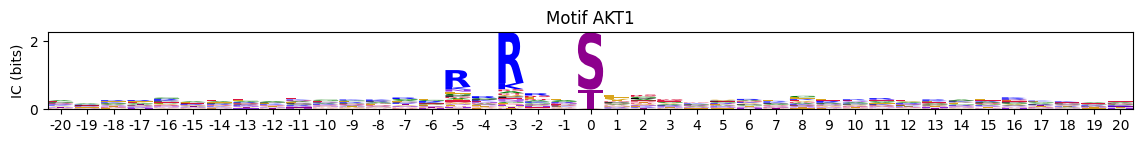

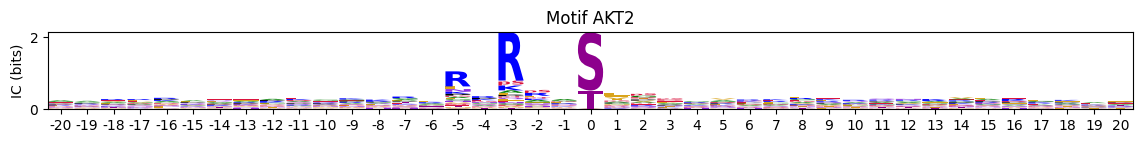

In [ ]:
plot_logos_idx(pssms,'AKT1','AKT2')

In one figure:

In [ ]:
#| export
def plot_logos(pssms_df, 
               count_dict=None, # used to display n in motif title
               prefix='Motif',
               figsize=(14,1)
               ):
    """
    Plot all logos from a dataframe of flattened PSSMs as subplots in a single figure.
    """
    n = len(pssms_df)
    hspace=0.7
    # 14 is width, 1 is height for each logo
    width,height=figsize
    fig, axes = plt.subplots(nrows=n, figsize=(width, n * (height+hspace)),gridspec_kw={'hspace': hspace+0.1})

    if n == 1:
        axes = [axes]  # ensure axes is iterable

    for ax, idx in zip(axes, pssms_df.index):
        pssm = recover_pssm(pssms_df.loc[idx])
        if count_dict is not None:
            plot_logo(pssm, title=f"{prefix or ''} {idx} (n={count_dict[idx]:,})",ax=ax)
        else:
            plot_logo(pssm, title=f"{prefix or ''} {idx}",ax=ax)

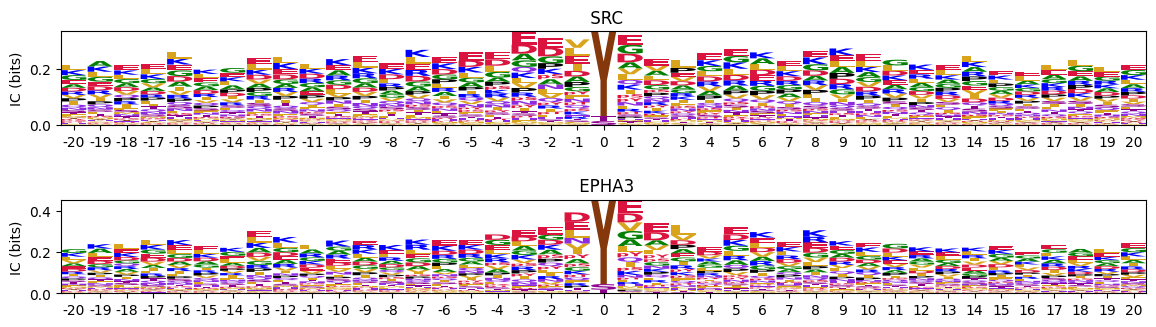

In [ ]:
plot_logos(pssms.head(2),prefix=None)

In [ ]:
plt.close('all')

## Logo motif + Heatmap

In [ ]:
#| export
def plot_logo_heatmap(pssm_df, # column is position, index is aa
                       title='Motif',
                       figsize=(17,10),
                       include_zero=False
                      ):
    
    """Plot logo and heatmap vertically"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[4, 1], hspace=0.11, wspace=0)

    ax_logo = fig.add_subplot(gs[0, 0])
    plot_logo(pssm_df,ax=ax_logo,title=title)

    ax_heatmap = fig.add_subplot(gs[1, :])
    plot_heatmap(pssm_df,ax=ax_heatmap,position_label=False,include_zero=include_zero)

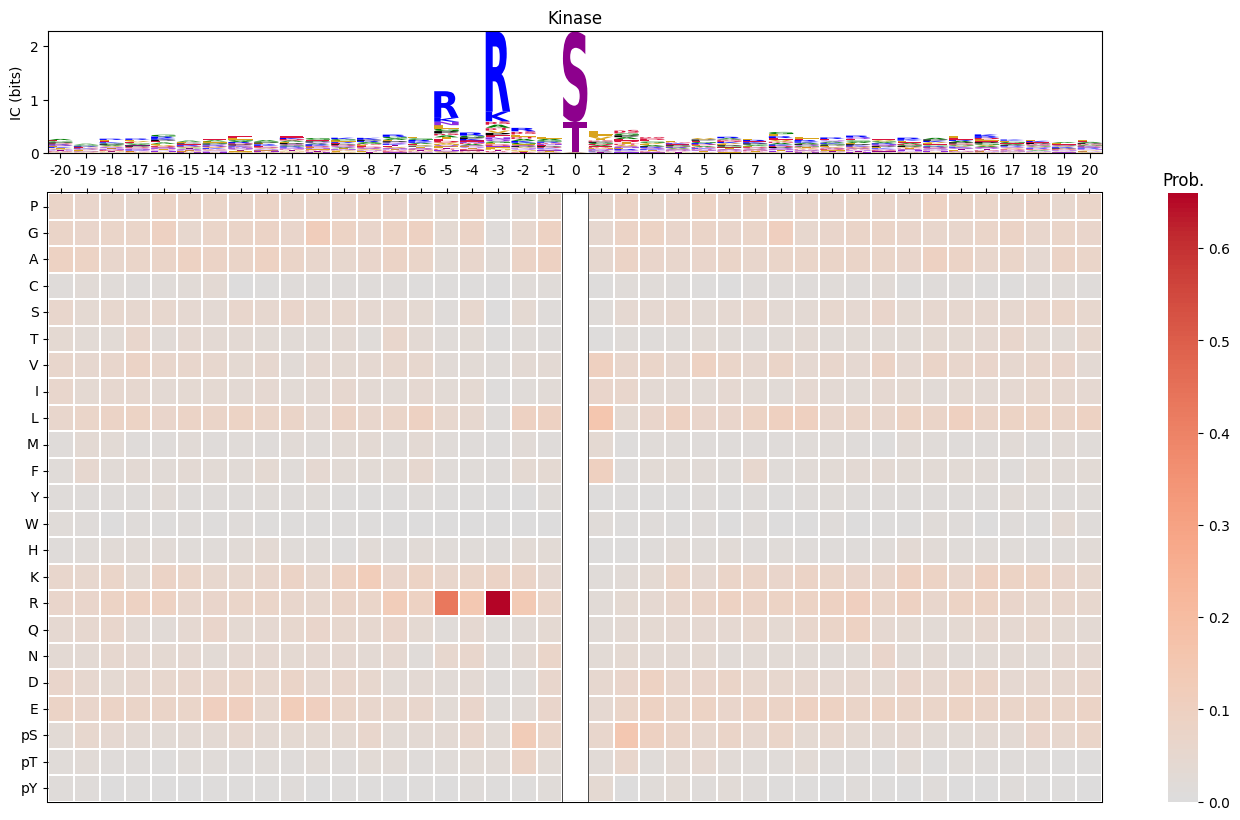

In [ ]:
plot_logo_heatmap(pssm_df,title='Kinase',figsize=(17,10))

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()